In [52]:
from pyspark.sql import SparkSession
from pyspark import SparkFiles
import pyspark.sql.functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [70]:
spark = SparkSession.builder.appName('MySparkApp').getOrCreate()

In [71]:
base_url = 'https://www.gutenberg.org/cache/epub/'
plays = [
    '27761/pg27761.txt',  # Hamlet
    '1533/pg1533.txt',    # Macbeth
    '1531/pg1531.txt'     # Othello
]

In [79]:
total_df = None

# Loop through each play and process the text
for play in plays:
    url = f'{base_url}{play}'
    spark.sparkContext.addFile(url)
    file = play.split('/')[-1]
# Read the text file into a df
    df = spark.read.text(SparkFiles.get(file))
# Split lines into words and explode into rows
    df = df.select(F.explode(F.split(df.value, ' ')).alias('word'))
# Clean punctuation, convert to lowercase, and filter out empty words
    df = df.select(F.regexp_replace(F.col('word'), r'[^\w\s]', '').alias('word'))
    df = df.filter(F.col('word') != '')
    df = df.select(F.lower(F.col('word')).alias('word'))
# Union dfs if total_df already exists
    if total_df is None:
        total_df = df
    else:
        total_df = total_df.union(df)

In [73]:
# Show total word count and individual word counts
total_df.show()
total_df.select(F.count('word')).show()

+---------+
|     word|
+---------+
|      the|
|  project|
|gutenberg|
|    ebook|
|       of|
|   hamlet|
|   prince|
|       of|
|  denmark|
|     this|
|    ebook|
|       is|
|      for|
|      the|
|      use|
|       of|
|   anyone|
| anywhere|
|       in|
|      the|
+---------+
only showing top 20 rows

+-----------+
|count(word)|
+-----------+
|      87262|
+-----------+



In [74]:
# Aggregate and sort word counts
word_counts = total_df.groupBy('word').count().orderBy(F.desc('count'))

In [75]:
# Convert Spark df to Pandas df for visualization
word_counts_pd = word_counts.toPandas()

In [76]:
# Display the top 50 words
top_words_df = word_counts_pd.head(50)
print(top_words_df)

         word  count
0         the   3332
1         and   2298
2          of   1979
3          to   1950
4           i   1583
5           a   1488
6         you   1343
7          in   1199
8          my   1008
9        that    965
10         is    900
11         it    854
12        not    830
13       with    759
14       this    707
15        for    632
16         be    605
17       your    589
18         me    575
19        his    574
20        but    535
21         he    513
22         or    511
23       have    509
24         as    503
25   footnote    480
26         do    464
27       what    432
28        him    407
29         so    387
30       will    382
31         by    371
32        are    369
33       iago    354
34         if    340
35        her    331
36        all    326
37    othello    325
38         on    316
39         no    311
40       thou    308
41    macbeth    286
42       from    286
43       lord    281
44      _ham_    280
45      shall    274
46    project

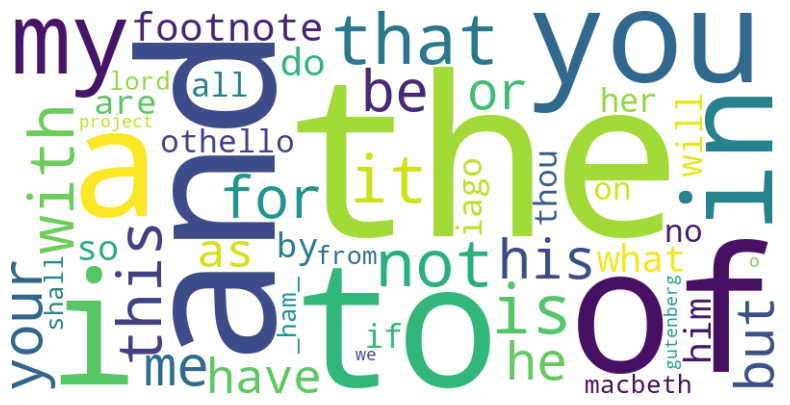

In [77]:
# Create a word cloud 
frequencies = pd.Series(top_words_df['count'].values, index=top_words_df['word']).to_dict()
wc = WordCloud(background_color="white", width=800, height=400).generate_from_frequencies(frequencies)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

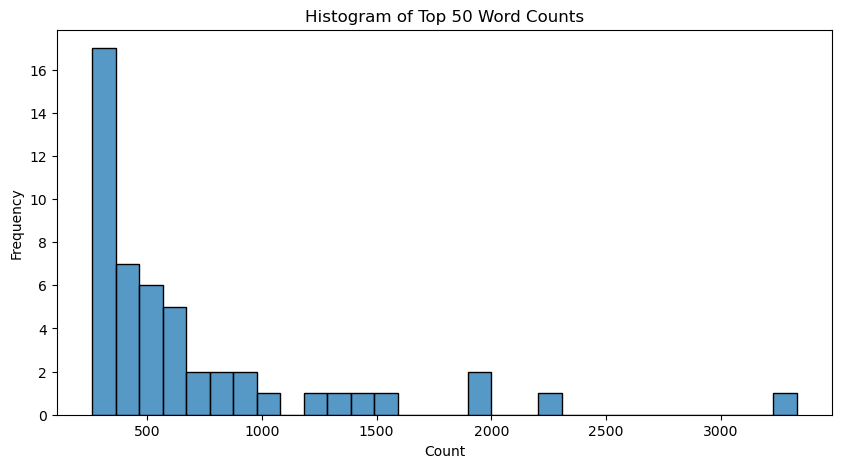

In [78]:
# Create a histogram of word frequencies 
plt.figure(figsize=(10, 5))
sns.histplot(top_words_df['count'], bins=30, kde=False)
plt.title('Histogram of Top 50 Word Counts')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()